Processing E:\newdata\img1.PNG
Noisy PSNR (Poisson, Color): 30.53 dB
Noisy SSIM (Poisson, Color): 0.5236
Denoised PSNR (Poisson, Color): 35.82 dB
Denoised SSIM (Poisson, Color): 0.8921
Noisy PSNR (Gaussian, Color): 27.92 dB
Noisy SSIM (Gaussian, Color): 0.0666
Denoised PSNR (Gaussian, Color): 27.92 dB
Denoised SSIM (Gaussian, Color): 0.0669


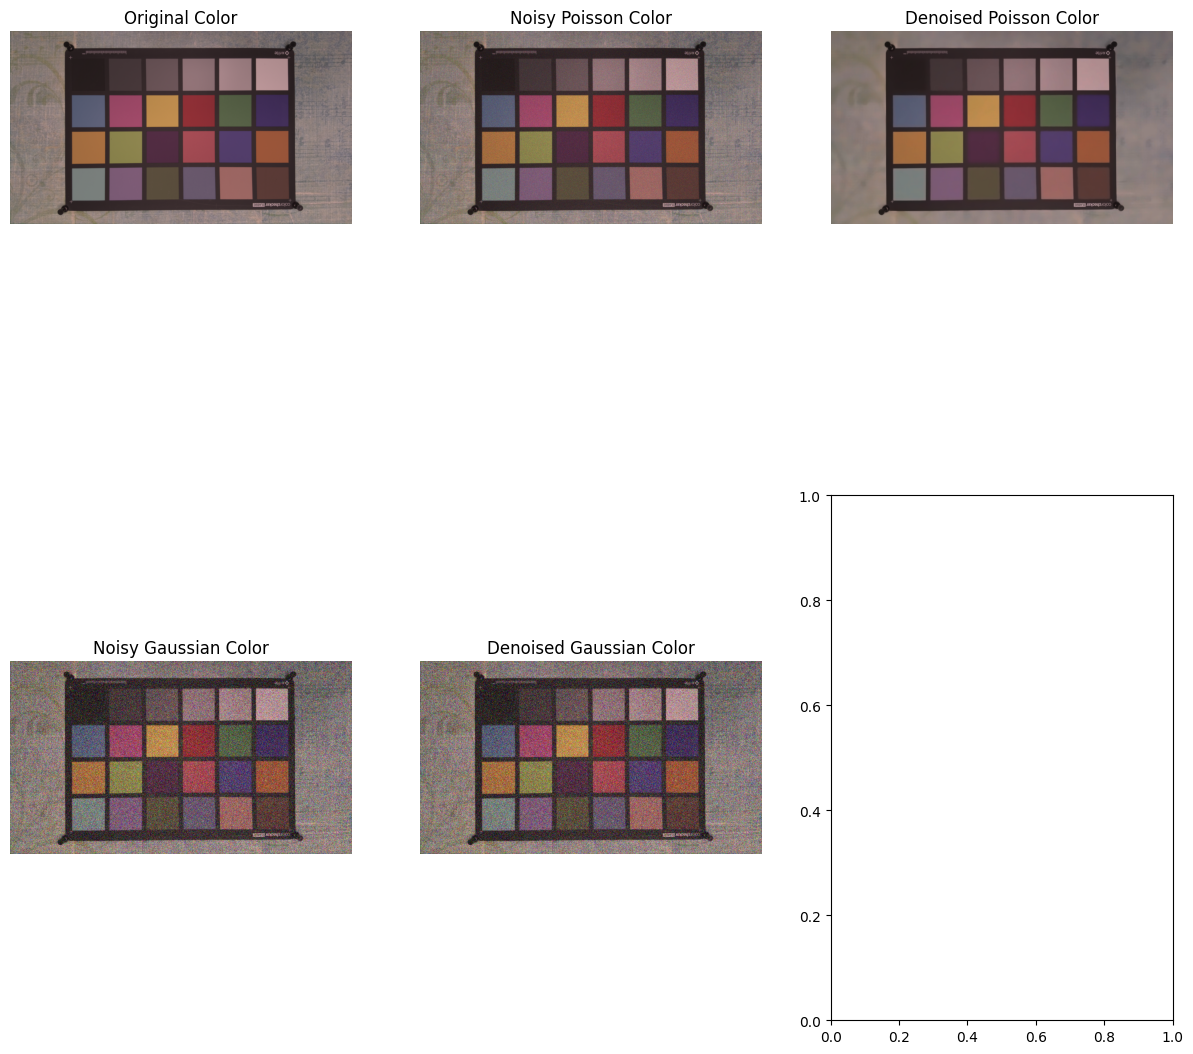

Processing E:\newdata\img2.PNG
Noisy PSNR (Poisson, Color): 31.91 dB
Noisy SSIM (Poisson, Color): 0.6178
Denoised PSNR (Poisson, Color): 38.99 dB
Denoised SSIM (Poisson, Color): 0.9438
Noisy PSNR (Gaussian, Color): 27.92 dB
Noisy SSIM (Gaussian, Color): 0.0529
Denoised PSNR (Gaussian, Color): 27.92 dB
Denoised SSIM (Gaussian, Color): 0.0530


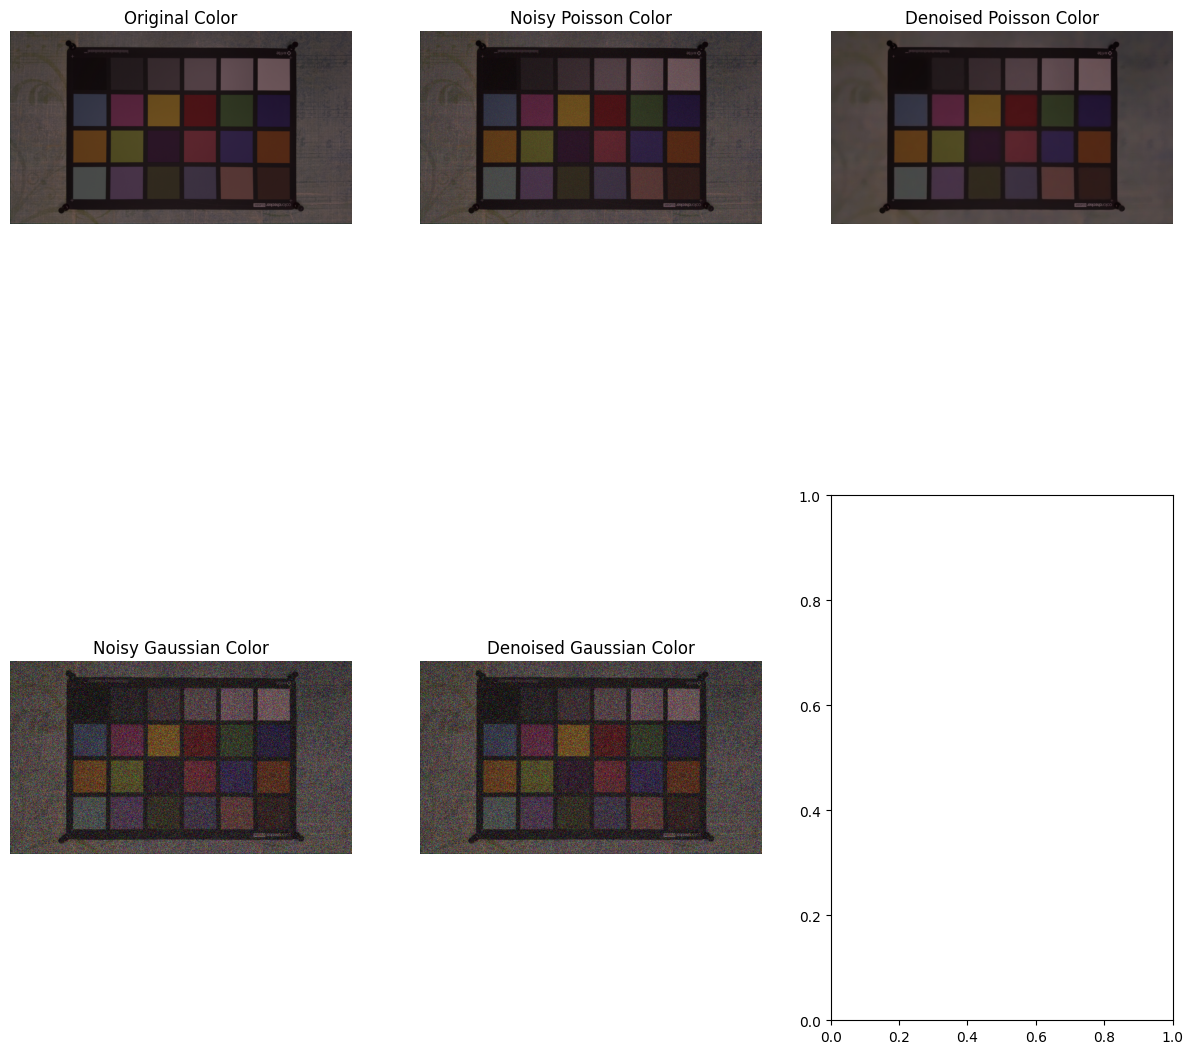

Processing E:\newdata\img3.PNG
Noisy PSNR (Poisson, Color): 29.94 dB
Noisy SSIM (Poisson, Color): 0.4839
Denoised PSNR (Poisson, Color): 33.83 dB
Denoised SSIM (Poisson, Color): 0.8560
Noisy PSNR (Gaussian, Color): 28.04 dB
Noisy SSIM (Gaussian, Color): 0.1000
Denoised PSNR (Gaussian, Color): 28.36 dB
Denoised SSIM (Gaussian, Color): 0.2160


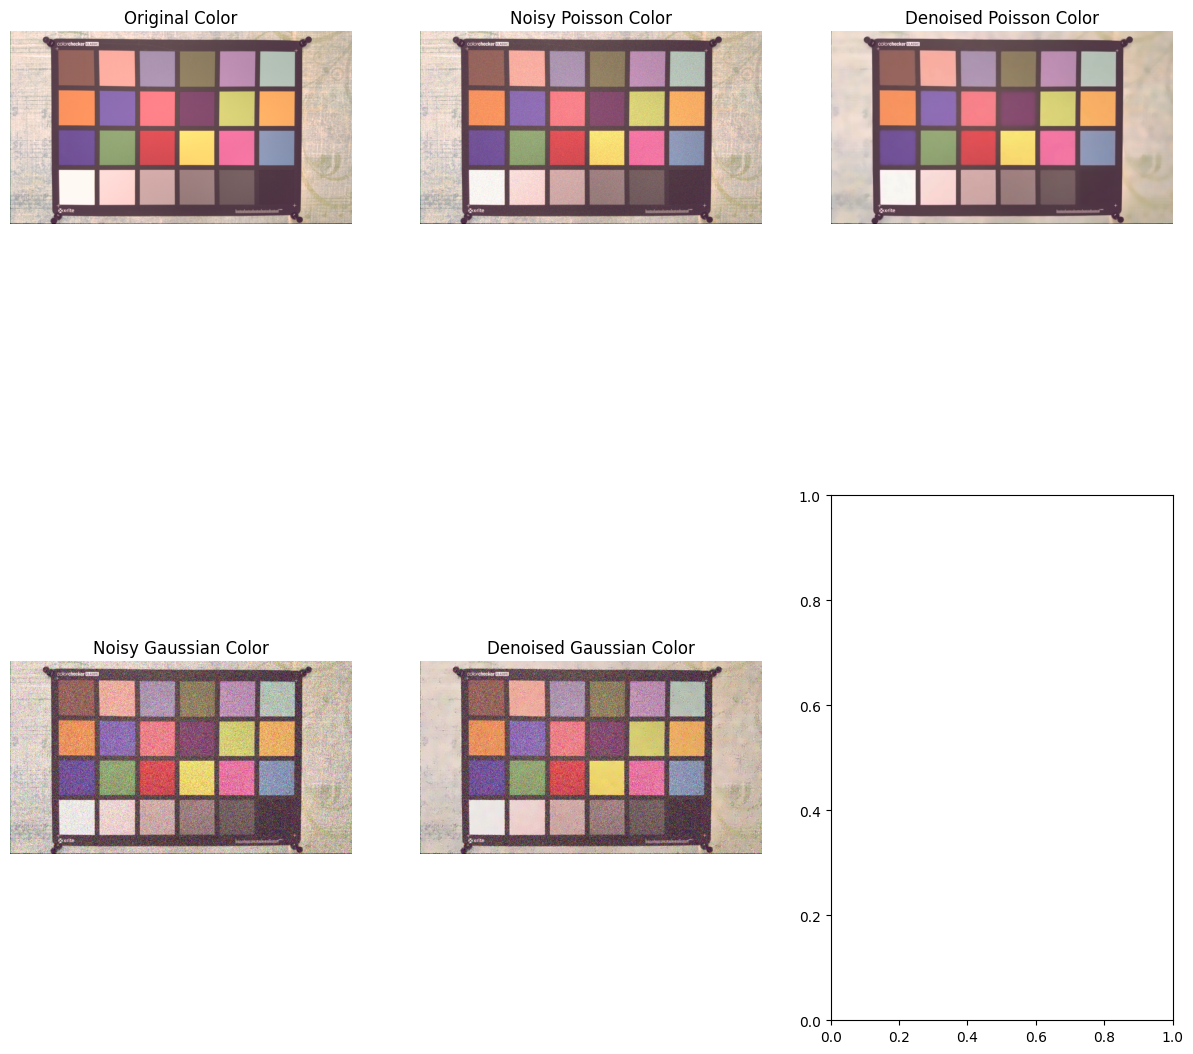

Processing E:\newdata\img4.PNG
Noisy PSNR (Poisson, Color): 30.20 dB
Noisy SSIM (Poisson, Color): 0.5046
Denoised PSNR (Poisson, Color): 33.57 dB
Denoised SSIM (Poisson, Color): 0.8134
Noisy PSNR (Gaussian, Color): 27.95 dB
Noisy SSIM (Gaussian, Color): 0.0579
Denoised PSNR (Gaussian, Color): 28.05 dB
Denoised SSIM (Gaussian, Color): 0.0793


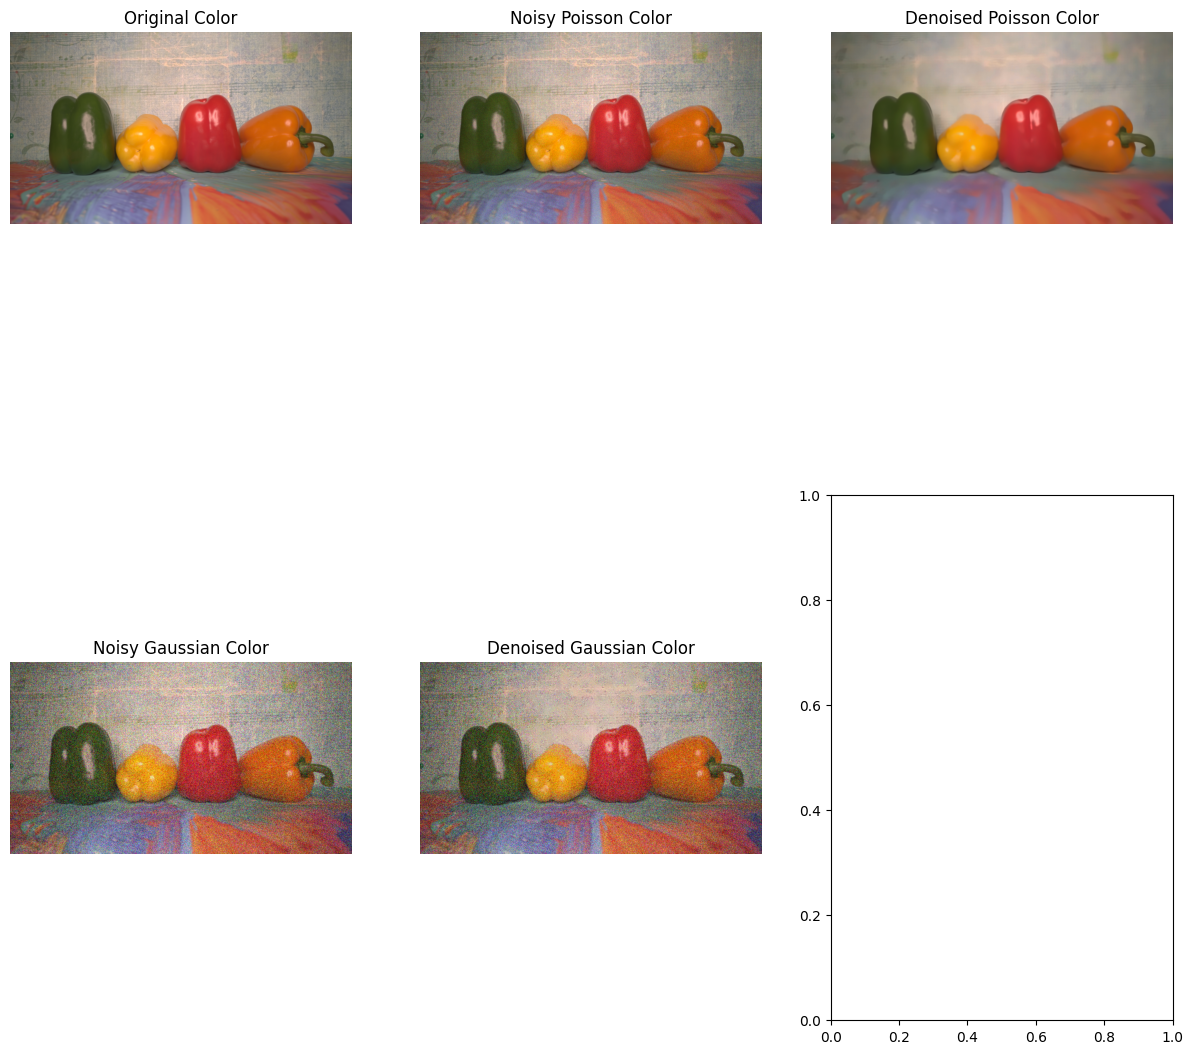

Processing E:\newdata\img5.PNG
Noisy PSNR (Poisson, Color): 33.86 dB
Noisy SSIM (Poisson, Color): 0.7481
Denoised PSNR (Poisson, Color): 40.54 dB
Denoised SSIM (Poisson, Color): 0.9625
Noisy PSNR (Gaussian, Color): 28.10 dB
Noisy SSIM (Gaussian, Color): 0.0552
Denoised PSNR (Gaussian, Color): 28.10 dB
Denoised SSIM (Gaussian, Color): 0.0556


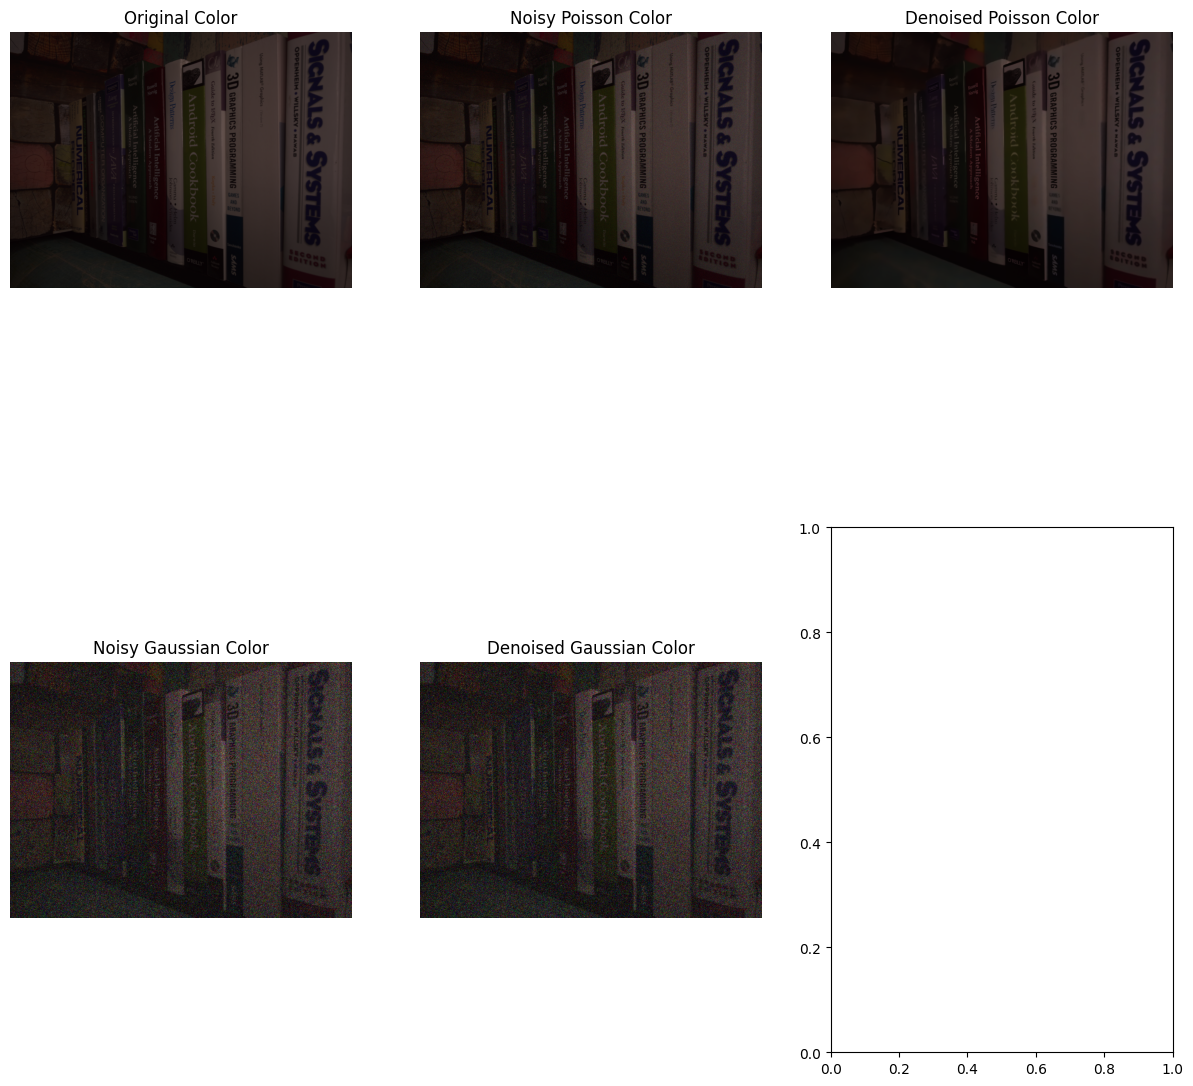

In [1]:
import os
import numpy as np
from scipy.stats import poisson
import cv2
import matplotlib.pyplot as plt

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(original, noisy):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(original, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(noisy, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(original ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(noisy ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(original * noisy, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_value = ssim_map.mean()

    return ssim_value

def add_poisson_noise(image):
    image = image.astype(np.float32) / 255.0
    noisy_image = np.random.poisson(image * 255) / 255.0
    noisy_image = np.clip(noisy_image * 255, 0, 255).astype(np.uint8)
    return noisy_image

def add_gaussian_noise(image, mean=0, sigma=50):
    if len(image.shape) == 2:  # Grayscale image
        noise = np.random.normal(mean, sigma, image.shape)
        noisy_image = image + noise
    else:  
        noisy_image = np.zeros_like(image, dtype=np.float32)
        for i in range(image.shape[2]):
            noise = np.random.normal(mean, sigma, image[:, :, i].shape)
            noisy_image[:, :, i] = image[:, :, i] + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def resize_image(image, max_dim=1024):
    height, width = image.shape[:2]
    if max(height, width) > max_dim:
        scaling_factor = max_dim / float(max(height, width))
        image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    return image

# Set parameters
sigma_read = 0.1
total_gain = 500.0
noise_scale = 5.0
poisson_scale = 2.0

dataset_folder = "E:\\newdata"
plot_count = 0
max_plots = 5

for root, _, files in os.walk(dataset_folder):
    for file in files:
        if file.startswith('img') and file.endswith('.PNG'):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

            # Resize image to manageable dimensions
            image = resize_image(image)

            # Add Poisson noise
            noisy_image_poisson = add_poisson_noise(image)

            # Add Gaussian noise
            noisy_image_gaussian = add_gaussian_noise(image)

            # Denoise images
            denoised_image_poisson = cv2.fastNlMeansDenoisingColored(noisy_image_poisson, None, 10, 10, 7, 21)
            denoised_image_gaussian = cv2.fastNlMeansDenoisingColored(noisy_image_gaussian, None, 10, 10, 7, 21)

            # Calculate PSNR and SSIM
            psnr_noisy_poisson = psnr(image, noisy_image_poisson)
            ssim_noisy_poisson = ssim(image, noisy_image_poisson)

            psnr_denoised_poisson = psnr(image, denoised_image_poisson)
            ssim_denoised_poisson = ssim(image, denoised_image_poisson)

            psnr_noisy_gaussian = psnr(image, noisy_image_gaussian)
            ssim_noisy_gaussian = ssim(image, noisy_image_gaussian)

            psnr_denoised_gaussian = psnr(image, denoised_image_gaussian)
            ssim_denoised_gaussian = ssim(image, denoised_image_gaussian)

            # Print results
            print(f"Processing {image_path}")
            print(f"Noisy PSNR (Poisson, Color): {psnr_noisy_poisson:.2f} dB")
            print(f"Noisy SSIM (Poisson, Color): {ssim_noisy_poisson:.4f}")
            print(f"Denoised PSNR (Poisson, Color): {psnr_denoised_poisson:.2f} dB")
            print(f"Denoised SSIM (Poisson, Color): {ssim_denoised_poisson:.4f}")
            print(f"Noisy PSNR (Gaussian, Color): {psnr_noisy_gaussian:.2f} dB")
            print(f"Noisy SSIM (Gaussian, Color): {ssim_noisy_gaussian:.4f}")
            print(f"Denoised PSNR (Gaussian, Color): {psnr_denoised_gaussian:.2f} dB")
            print(f"Denoised SSIM (Gaussian, Color): {ssim_denoised_gaussian:.4f}")

            # Plot images
            if plot_count < max_plots:
                fig, axes = plt.subplots(2, 3, figsize=(15, 15))
                axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[0, 0].set_title('Original Color')
                axes[0, 0].axis('off')
                axes[0, 1].imshow(cv2.cvtColor(noisy_image_poisson, cv2.COLOR_BGR2RGB))
                axes[0, 1].set_title('Noisy Poisson Color')
                axes[0, 1].axis('off')
                axes[0, 2].imshow(cv2.cvtColor(denoised_image_poisson, cv2.COLOR_BGR2RGB))
                axes[0, 2].set_title('Denoised Poisson Color')
                axes[0, 2].axis('off')
                axes[1, 0].imshow(cv2.cvtColor(noisy_image_gaussian, cv2.COLOR_BGR2RGB))
                axes[1, 0].set_title('Noisy Gaussian Color')
                axes[1, 0].axis('off')
                axes[1, 1].imshow(cv2.cvtColor(denoised_image_gaussian, cv2.COLOR_BGR2RGB))
                axes[1, 1].set_title('Denoised Gaussian Color')
                axes[1, 1].axis('off')

                plt.show()
                plot_count += 1

            # Clear variables to free memory
            del image
            del noisy_image_poisson
            del noisy_image_gaussian
            del denoised_image_poisson
            del denoised_image_gaussian

            if plot_count >= max_plots:
                break
    if plot_count >= max_plots:
        break
